In [25]:
%%html
<style>
    /* Jupyter */
    .rendered_html tr, .rendered_html th, .rendered_html td {
        text-align: left; 
    }
</style>

# Holt-Winters Method for Time Series Forecasting

### Learning Objectives
- [Exponential Smoothing](#Exponential-Smoothing)
- [Level, Trend and Seasonality](#Level,-Trend-and-Seasonality)
- [Holt-Winters Method](#Holt-Winters-Method)
- [Python Implementation of Holt-Winters](#Python-Implementation-of-Holt-Winters)
- [Note on Initialising Parameters](#Note-on-Intitialising-Parameters)

In the introduction to time series notebook, we looked at some naive implementions for forecasting models - ranging from a naive 'fill' method to a weighted moving average model. We will pick up our journey from this point of departure, eventually building up to a forecasting method known as **Holt-Winters**. To reach there, we start with the concept of **exponential smoothing**.

# Exponential Smoothing

Now let's consider a weighted average method where we consider __all__ of the observed data points. We want the most recent observations to be weighted the highest whilst the weights decrease __exponentially__ as the observations go further back into the past. This method of forecasting is called __exponential smoothing__ as the weights decay exponentially as we continue to go back to observed points in time.

For example the set of weights used could look like:

$$0.8, 0.8^2, 0.8^3, 0.8^4, 0.8^5, 0.8^6 \cdots$$ or equivalently 

$$0.8, 0.64, 0.512, 0.4096, 0.32768, 0.262144 \cdots$$

The issue here is that these weights do not add up to 1 (using geometric series the sum of the weights in the example above approaches 4).

To solve this issue, exponential smoothing can be encapsulated in conscise and elegant formula:

$$\mathbf{\hat{y_{x+1}}=\alpha \cdot y_{x}+(1-\alpha) \cdot \hat{y_{x-1}}}$$

where

$y_{x} =$ actual value at time x

$\alpha =$ smoothing factor 

$\hat{y_{x-1}} =$ smoothed value at time x-1

To forecast beyond the last data point: $\hat{y_{x+h}} = \hat{y_{x}} $

In a way you can consider exponential smoothing to be a weighted average of two different terms $y_{x}$ and $\hat{y_{x}}$, also now the weights $\alpha$ and $(1-\alpha)$ sum to 1. We can convince ourselves that this succint formula really is equivalent to exponential smoothing by substituting a couple of terms in:
$$
\begin{align}
\hat{y_{x+1}} &= \alpha \cdot y_{x}+(1-\alpha) \cdot \hat{y_{x-1}}
\\&= \alpha \cdot y_{x}+(1-\alpha) \cdot \lbrack \alpha \cdot y_{x-1}+(1-\alpha) \cdot \hat{y_{x-2}}\rbrack
\\&= \alpha \cdot y_{x}+\alpha \cdot (1-\alpha) \cdot y_{x-1}+(1-\alpha)^{2} \cdot \hat{y_{x-2}}
\\\vdots
\\&= \alpha \cdot y_{x}+\alpha(1-\alpha) \cdot y_{x-1} + \alpha(1-\alpha)^{2} \cdot y_{x-2}+ \alpha(1-\alpha)^{3} \cdot y_{x-3}+ \alpha(1-\alpha)^{4} \cdot y_{x-4}+\dots 
\end{align}
$$

By subsituting in more terms recursively we can now see that going back to the beginning of the series (or infinitely backwards), the weights are generated by multiplying $(1-\alpha)$. This is the same as exponential smoothing but now we have a nicer way to represent this.

The parameter $\mathbf{\alpha}$ is referred to as the __smoothing factor__ and can take values $0 \leq \alpha \leq 1$. A large value of $\alpha$ gives more weight to recent changes, the smaller the value of $\alpha$ more distant points are taken into consideration when making the focus. In a way the larger the value of $\alpha$ the quicker the method "forgets" past observations.

In theory, a time series can go back infinitely but in practise when forecasting we can choose a point in time to start our time series. 

The function below takes in a series and applies exponential smoothing to it

In [34]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value of exponential series is same as the original time series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    result.append(result[-1])
    return result

Let's take a look at exponential smoothing applied to our AI Core example.

Text(0.5, 1.0, 'Number of students at AI Core')

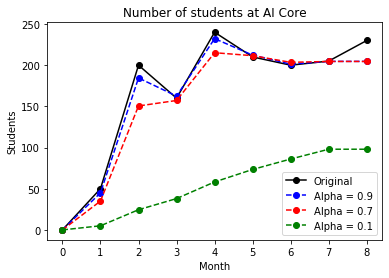

In [35]:
example1 = exponential_smoothing(aicore_series[:-1],0.9)
example2 = exponential_smoothing(aicore_series[:-1],0.7)
example3 = exponential_smoothing(aicore_series[:-1],0.1)
#Plot observed series
plt.plot(aicore_series,'ko-', label='Original')
plt.plot(example1, 'bo--', label='Alpha = 0.9')
plt.plot(example2, 'ro--', label='Alpha = 0.7')
plt.plot(example3, 'go--', label='Alpha = 0.1')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Students')
plt.title('Number of students at AI Core')
#plt.plot(example1, 'bo--', label='Alpha = 0.9')

Compared to the actual value we observe, we can see that with a suitable value for alpha the exponential smoothing method fits the actual series fairly  well and can produce a reasonable forecast. 

So far all of the forecasting methods discussed can only be used to forecast a single datapoint into the future. The rest of the notebook will take a look at how building on exponential smoothing we can get to a more useful model that can be used to predict further into the future and take into account other characteristics of the time series we are trying to forecast. 

# Level, Trend and Seasonality
The __level__ of a time series is the expected value/average value of a time series. Note: As the Holt-Winters method for forecasting uses the level as part of the calculation, it is referred to as $\mathbf{l}$ instead of $\mathbf{\hat{y}}$.

The __trend__ is the slope of long-term increase or decrease in the data. Trend is denoted by $\mathbf{b}$ and is given by $\mathbf{b=y_{x} - y_{x-1}}$ for a linear trend. Below is an example of a time series with an overall positive trend.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

df = pd.read_csv('../../DATA/apple.csv')
fig = px.line(df, x = 'Date', y = 'Close', title='Apple Share Prices over time (2014)')
fig.update_layout(title={'text': "Apple Share Prices over time ",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

If a time series repeats at a fixed frequency then this interval is known as it's __season__. The __season length__ is the number of data points within a season, this is denoted by __L__. Below is a time series which displays __seasonality__.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

df = pd.read_csv('../../DATA/airpassengers.csv')
fig = px.line(df, x = 'Month', y = '#Passengers', title='Air Passenger Data')
fig.update_layout(title={'text': "Number of monthly Air Passengers",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

# Holt-Winters Method

The __Holt-Winters model__ (also referred to as __triple exponential smoothing__) predicts a current or future value by computing the combined effects of level, trend and seasonality. Note that non-seasonal series cannot be forecasted using the Holt-Winters method.

The idea behind the Holt-Winters model is to apply exponential smoothing to the level, trend and seasonal components. The smoothing is applied across the seasons e.g. the 2nd point of the season would be exponentially smoothed with the 2nd point of the second season, the 2nd point from the third season etc.

## Holts-Winters Method Formulas:

__Level__: $\ell_{t} =\alpha(y_{t}- s_{t-L})+(1-\alpha)(\ell_{t-1}+b_{t-1})$

__Trend__: $b_{t}=\beta(\ell_{t}-\ell_{t-1})+(1-\beta)b_{t-1}$

__Seasonal__: $s_{t}=\gamma (y_{t}-\ell_{t})+(1-\gamma)s_{t-L}$

__Forecast__: $\hat{y_{t+m}}=\ell_{t}+mb_{t} + s_{t-L+1+(m-1) mod L} $

where 

$\mathbf{\alpha}=$ smoothing paramenter for level component

$\mathbf{\beta}=$ smoothing parameter for trend component

$\mathbf{\gamma}=$ smoothing parameter for seasonal component

$m =$ time index being forecasted (integer) 

$L=$ season length

$\ell_{t} = $level component at time t

$b_{t}= $trend component at time t

$s_{t}=$ seasonal component at time t

The time index t+m can take any integer value meaning we can now forecast any number of time steps into the future!!! 

# Note on Initialising Parameters
#### Trend, Slope, Alpha, Beta, Gamma
The simplest way to optimize the values of alpha, beta, gamma is to run the Holt-Winters method on a set of known observed values and choose the parameters which minimize the SSE. Trial and error should give a reasonable estimate for alpha, beta and gamma. A better way to optimise for alpha, beta, gamma is to use the Nelder - Mead algorithm.

See the links below for extra information on this:

https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method

https://codesachin.wordpress.com/2016/01/16/nelder-mead-optimization/

## Initialising Holt-Winters
__Initial trend__ for a time series with a seasonal component can be found by taking the average of the trend averages across each season. i.e. 

$b_{0}=\frac{1}{L}(\frac{{y_{L+1}} − {y_{1}}}{L}+\frac{{y_{L+2}} − {y_{2}}}{L}+\cdots+\frac{{y_{L+L}} − {y_{L}}}{L})$

In [38]:
# Python Implementation of initialising trend
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

The code below computes the __initial seasonal component__. For more information on the mathematics behind this see the following link : https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm.

In [39]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

# Python Implementation of Holt-Winters
Finally let's implement the Holt-Winters algorithm in Python. The Holt-Winters algorithm below uses the initial_trend function and the initial_seasonal_components function above.

In [40]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

Let's run through an example of applying the Holt-Winters algorithm. Here's an example series below.

In [41]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

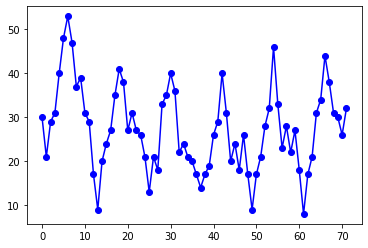

In [42]:
import matplotlib.pyplot as plt
plt.plot(series, 'bo-')

It's clear that this series is seasonal, there are 6 seasons in total in the series. For Holt-Winters we need to know the season length (L) and in this case the season length is 12. Firstly let's split our series into test data and training data to see how Holt's Winters compares to the observed values we see. In this example let's take the first 4 seasons as our training data and use the last two seasons as our test data. 


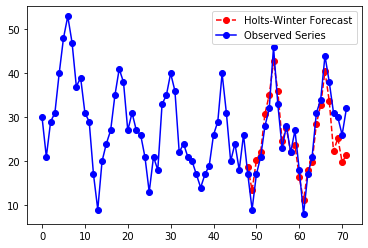

In [43]:
result = triple_exponential_smoothing(series[:48], 12, 0.716, 0.029, 0.993, 24)
import matplotlib.pyplot as plt

plt.plot(range(48,72),result[-24:], 'ro--', label='Holts-Winter Forecast')
plt.plot(series, 'bo-', label='Observed Series')
plt.legend()

The Holts-Winter Algorithm does pretty well to forecast the observed series for the most part!

Now let's forecast two seasons ahead into the future i.e. 24 time steps into the future.

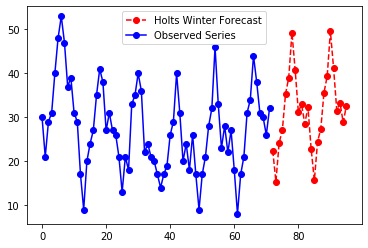

In [44]:
result = triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 24)
import matplotlib.pyplot as plt

plt.plot(range(72,96),result[-24:], 'ro--',label='Holts Winter Forecast')
plt.plot(series, 'bo-',label='Observed Series')
plt.legend()

# Holt-Winters in the real world

Throughout this notebook we've had a look at a step-by-step guide at constructing the Holt-Winters algorithm. in practice there are libraries available in Python which can carry out and optimizes the parameters in the Holt-Winters forecasting method according to the dataset. Below is an example of Holt-Winters method applied to forecast air passenger data using the __statsmodels__ library in Python.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



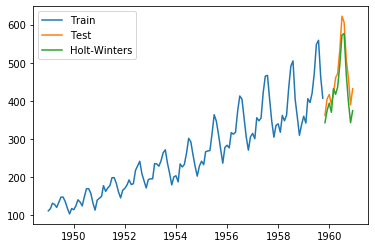

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df = pd.read_csv('../../DATA/airpassengers.csv', 
                parse_dates=['Month'], 
                 index_col='Month'
)
df.index.freq = 'MS'
train, test = df.iloc[:130, 0], df.iloc[130:, 0]
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

__Congratulations!__ Now you can use the Holt-Winters algorithm for forecasting any seasonal time series!